In [1]:
# # prompt: mount google drive and copy a csv file and also unmount

# from google.colab import drive
# drive.mount('/content/drive')
# !cp /content/drive/MyDrive/Colab\ Notebooks/recv_dupli.csv /content/
# !cp /content/drive/MyDrive/Colab\ Notebooks/close_dupli.csv /content/

# !ls
# drive.flush_and_unmount()


Mounted at /content/drive
close_dupli.csv  drive	recv_dupli.csv	sample_data


In [1]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import warnings
from matplotlib.pyplot import figure

In [2]:
today_price_df = pd.read_csv("recv_dupli.csv")

columns_to_drop = ['companyName', 'change', 'pChange', 'updatedOn',
                   'previousClose', 'previousOpen', 'dayHigh', 'dayLow',
                   'totalTradedValue', 'totalTradedQuantity', 'buy', 'sell']

today_price_df.drop(columns=columns_to_drop, inplace = True)

def convert_to_int(value):
    try:
        # Split the value into numeric and text parts
        parts = value.strip().split()

        # Extract the numeric part and remove commas
        numeric_value = float(parts[0].replace(',', ''))

        # If the value contains 'Lakh', multiply by 100,000
        if 'Lakh' in parts:
            numeric_value *= 100000

        # If the value contains 'Cr.', multiply by 10,000,000
        elif 'Cr.' in parts:
            numeric_value *= 10000000

        # Round to the nearest integer
        result = int(round(numeric_value))

        return result

    except ValueError:
        # Return None if the conversion fails
        return None

# Apply the conversion function to each column
today_price_df['2WeekAvgQuantity'] = today_price_df['2WeekAvgQuantity'].apply(convert_to_int)
today_price_df['marketCapFull'] = today_price_df['marketCapFull'].apply(convert_to_int)
today_price_df['marketCapFreeFloat'] = today_price_df['marketCapFreeFloat'].apply(convert_to_int)


In [3]:
# Assuming timed_df is your DataFrame indexed by date
orig_df = pd.read_csv("close_dupli.csv")
timed_df = orig_df.fillna(0)

timed_df['Date'] = pd.to_datetime(timed_df['Date'])
timed_df.set_index('Date', inplace=True)
# Set the desired start and end dates
start_date = '2022-11-01'
end_date = '2023-01-01'

# Use loc to select rows within the specified date range
# timed_df = timed_df.loc[start_date:end_date]

# Set the desired number of columns to keep
num_columns_to_keep = 5  # Replace with your desired number

# Use iloc to select the first num_columns_to_keep columns
timed_df = timed_df.iloc[:, :num_columns_to_keep]
timed_df

,ABB,AEGISLOG,AMARAJABAT,AMBALALSA,ANDHRAPET
Date,,,,,
2000-01-03,53.989998,0.000000,0.000000,0.000000,0.000000
2000-01-04,52.599998,0.000000,0.000000,0.000000,0.000000
2000-01-05,52.200001,0.000000,0.000000,0.000000,0.000000
2000-01-06,56.000000,0.000000,0.000000,0.000000,0.000000
2000-01-07,54.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2023-10-06,4132.799805,326.799988,644.150024,40.500000,77.339996
2023-10-09,4095.149902,322.700012,634.549988,41.310001,74.269997
2023-10-10,4189.149902,323.299988,635.250000,42.130001,74.580002


In [4]:
sym = "AMARAJABAT"
timed_df = timed_df[sym]

In [7]:
config = {
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    },
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 30,
    }
}

Number data points: 5859 from  + 2000-01-03 00:00:00 to 2023-10-12 00:00:00


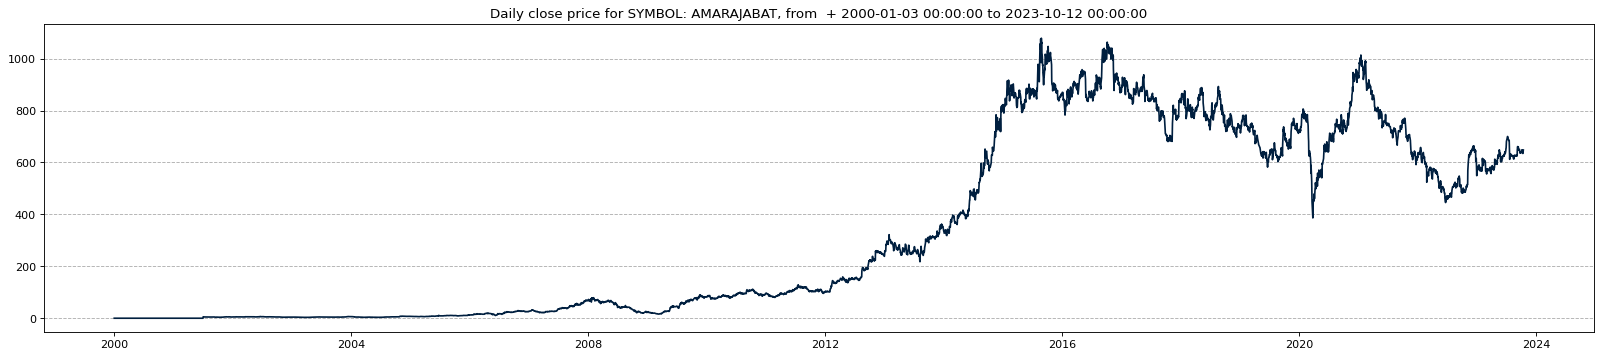

In [8]:
data_date = [date for date in timed_df.keys()]
# data_date.reverse()
data_close_price = [i for i in timed_df]
# data_close_price.reverse()
data_close_price = np.array(data_close_price)
num_data_points = len(data_date)
display_date_range = f"from  + {data_date[0]} to {data_date[num_data_points-1]}"
print("Number data points:", num_data_points, display_date_range)

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
# plt.xticks(x, xticks, rotation='vertical')
plt.grid(visible=None,which='major', axis='y', linestyle='--')
plt.title("Daily close price for " + f"SYMBOL: {sym}" + ", " + display_date_range)
plt.show()


In [9]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None
    
    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(np.array(timed_df))

In [14]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides=(x.strides[0],x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    return output

def prepare_data(normalized_data_close_price, config, plot=False):
    data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
    data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

    # split dataset

    split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]


    #     # prepare data for plotting

    #     to_plot_data_y_train = np.zeros(num_data_points)
    #     to_plot_data_y_val = np.zeros(num_data_points)

    #     to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train)
    #     to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(data_y_val)

    #     to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
    #     to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

    #     ## plots

    #     fig = figure(figsize=(25, 5), dpi=80)
    #     fig.patch.set_facecolor((1.0, 1.0, 1.0))
    #     plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
    #     plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
    #     xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
    #     x = np.arange(0,len(xticks))
    #     plt.xticks(x, xticks, rotation='vertical')
    #     plt.title("Daily close prices for " + config["alpha_vantage"]["symbol"] + " - showing training and validation data")
    #     plt.grid(b=None, which='major', axis='y', linestyle='--')
    #     plt.legend()
    #     plt.show()

    return split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen

split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen = prepare_data(normalized_data_close_price, config, plot=config["plots"]["show_plots"])


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [16]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

Train data shape (4671, 20, 1) (4671,)
Validation data shape (1168, 20, 1) (1168,)


In [17]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)

        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)

        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1)

        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

In [18]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

# create `DataLoader`
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

# begin training
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()

    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))



Epoch[1/100] | loss train:0.053126, test:0.021303 | lr:0.010000
Epoch[2/100] | loss train:0.017127, test:0.011242 | lr:0.010000
Epoch[3/100] | loss train:0.015104, test:0.011955 | lr:0.010000
Epoch[4/100] | loss train:0.015838, test:0.044634 | lr:0.010000
Epoch[5/100] | loss train:0.015879, test:0.020388 | lr:0.010000
Epoch[6/100] | loss train:0.013402, test:0.009081 | lr:0.010000
Epoch[7/100] | loss train:0.014150, test:0.019160 | lr:0.010000
Epoch[8/100] | loss train:0.013317, test:0.009608 | lr:0.010000
Epoch[9/100] | loss train:0.014116, test:0.008464 | lr:0.010000
Epoch[10/100] | loss train:0.014195, test:0.011548 | lr:0.010000
Epoch[11/100] | loss train:0.013578, test:0.013045 | lr:0.010000
Epoch[12/100] | loss train:0.013703, test:0.042149 | lr:0.010000
Epoch[13/100] | loss train:0.012203, test:0.007594 | lr:0.010000
Epoch[14/100] | loss train:0.015254, test:0.017506 | lr:0.010000
Epoch[15/100] | loss train:0.014945, test:0.020455 | lr:0.010000
Epoch[16/100] | loss train:0.01446

In [19]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

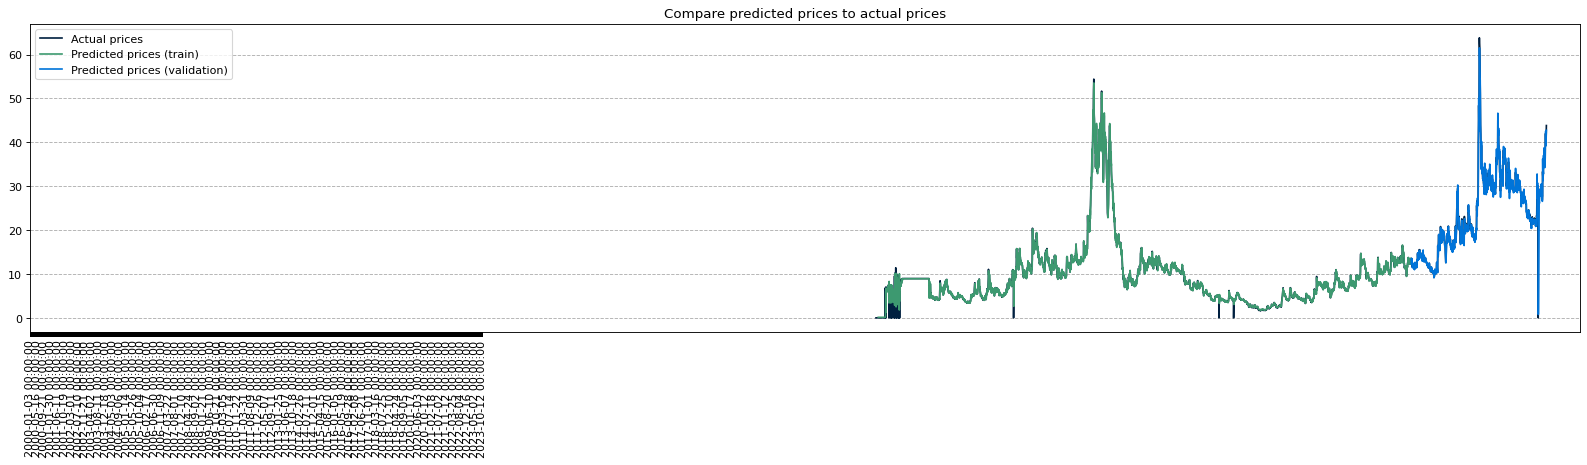

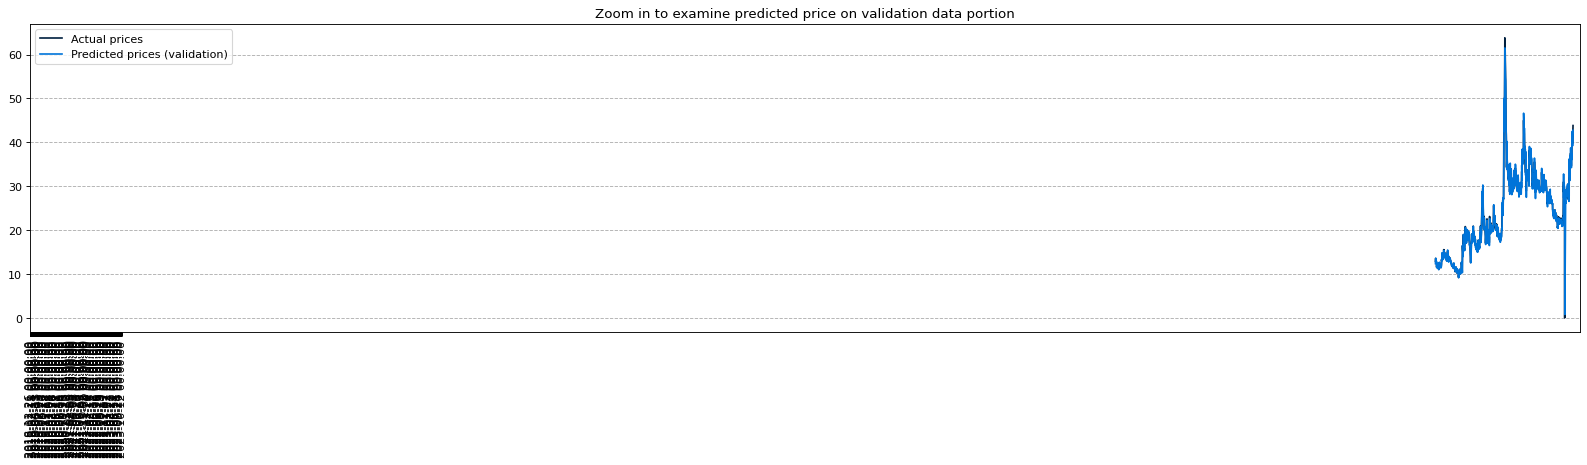

In [20]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

if config["plots"]["show_plots"]:

    # prepare data for plotting, show predicted prices

    to_plot_data_y_train_pred = np.zeros(num_data_points)
    to_plot_data_y_val_pred = np.zeros(num_data_points)

    to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
    to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
    plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Compare predicted prices to actual prices")
    xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
    x = np.arange(0,len(xticks))
    # plt.xticks(x, xticks, rotation='vertical')
    plt.grid(visible=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    # prepare data for plotting, zoom in validation

    to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
    to_plot_predicted_val = scaler.inverse_transform(predicted_val)
    to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Zoom in to examine predicted price on validation data portion")
    xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
    xs = np.arange(0,len(xticks))
    # plt.xticks(xs, xticks, rotation='vertical')
    plt.grid(visible=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

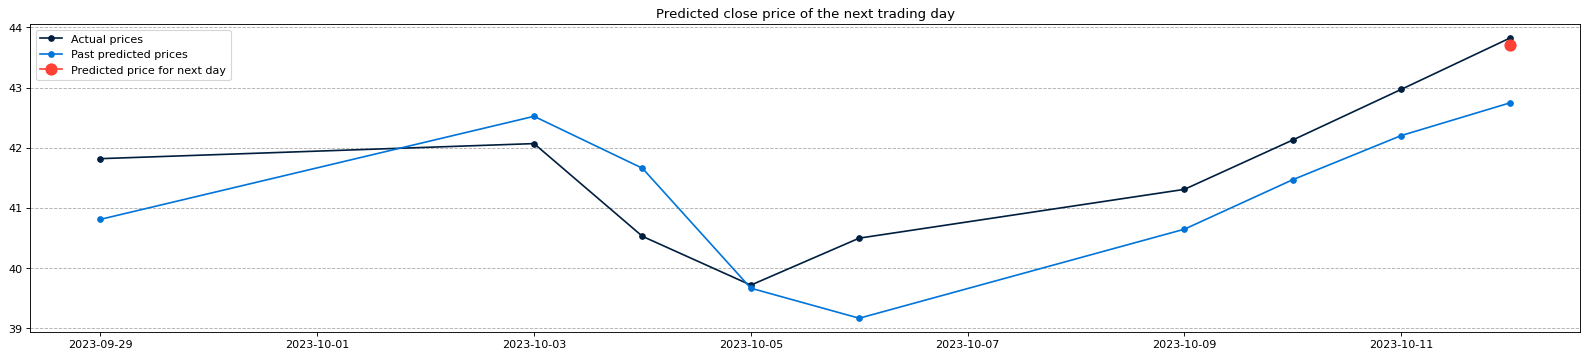

Predicted close price of the next trading day: 43.7


In [27]:
# predict on the unseen data, tomorrow's price

model.eval()

x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()
prediction = scaler.inverse_transform(prediction)[0]

if config["plots"]["show_plots"]:

    # prepare plots

    plot_range = 10
    to_plot_data_y_val = np.zeros(plot_range)
    to_plot_data_y_val_pred = np.zeros(plot_range)
    to_plot_data_y_test_pred = np.zeros(plot_range)

    to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val)[-plot_range+1:]
    to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]

    to_plot_data_y_test_pred[plot_range-1] = prediction

    to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

    # plot

    plot_date_test = data_date[-plot_range+1:]
    plot_date_test.append(data_date[-1])

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
    plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
    plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
    plt.title("Predicted close price of the next trading day")
    plt.grid(visible=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

print("Predicted close price of the next trading day:", round(prediction, 2))



In [ ]:
timed_df

In [ ]:
# timed_df.fillna(0, inplace=True)

In [ ]:
timed_df.columns

In [ ]:
# column_to_drop = 'UTIQUE'

# timed_df = timed_df.drop(column_to_drop, axis=1)


In [ ]:
# timed_df.dropna(inplace = True)

In [ ]:
# Show daily returns
returns = timed_df.pct_change()
returns.fillna(0, inplace=True)
returns.replace([np.inf, -np.inf], 0, inplace=True)

returns

In [ ]:
# Annualized covariance matrix

cov_matrix_annual = returns.cov()*252
cov_matrix_annual.fillna(0, inplace=True)
cov_matrix_annual

In [ ]:
weights = np.full(timed_df.shape[1], 1 / timed_df.shape[1])
weights

In [ ]:
# Calculate PORTFOLIO variance
port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
port_variance

In [ ]:
# Calculate PORTFOLIO volatility (std. dev)
port_volatility = np.sqrt(port_variance)
port_volatility

In [ ]:
# Annual portfolio return
portfolioSimpleAnnualReturn = np.sum(returns.mean() * weights) * 252
portfolioSimpleAnnualReturn

In [ ]:
# DISPLAY

percent_var = str(round(port_variance, 2)*100) + "%"
percent_vol = str(round(port_volatility, 2)*100) + "%"
percent_ret = str(round(portfolioSimpleAnnualReturn, 2)*100) + "%"

print ("Expected Annual Return: " + percent_ret)
print ("Annual Volatility: " + percent_vol)
print ("Annual Variance: " + percent_var)

# OPTIMAZATION

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [ ]:
mu = expected_returns.mean_historical_return(timed_df)

In [ ]:
# S = np.cov(timed_df, rowvar=False)
# S = (S + S.T) / 2  # Enforce symmetry
# S.(0, inplace=True)


In [ ]:
S = risk_models.sample_cov(timed_df)
# S = (S + S.T) / 2

# # S = np.array(S)
# S.is_hermitian()

In [ ]:
# S = risk_models.CovarianceShrinkage(timed_df).ledoit_wolf()
# S.fillna(0, inplace=True)
# S = np.array(S)


In [ ]:
S

In [ ]:
# S = (S + S.T) / 2

# sharpe ratio
ef = EfficientFrontier(mu, S)

weights = ef.max_sharpe()
refined_weights = ef.clean_weights()
print (refined_weights)
ef.portfolio_performance(verbose = True)

In [ ]:
refined_weights

In [ ]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(timed_df)
# weights = refined_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000)

allocation, leftover = da.lp_portfolio()
print ("Discrete Allocation: " , allocation )
print ("Funds Remaining: " , leftover )


which is number of shares that can be bought